In [35]:
import os
import yaml
import sys 

from pickle import dump
from pickle import load

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
# from sklearn.model_selection import KFold
# from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Parameter
import math
from torch.nn.modules.loss import _WeightedLoss
from torch.utils.tensorboard import SummaryWriter

import optuna
import joblib

from sklearn.metrics import roc_auc_score

import cv2

from tqdm import tqdm

In [2]:
# ライブラリ読み込み
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, glob, pickle, time, gc, copy, sys

import warnings
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100) # 表示できる表の列数

In [3]:
optimizer_name = 'Adam'
lr = 0.0007
patience = 500
EPOCHS = 5000000
input_size = 200
n_splits = 5
verbose = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
col_target = 'target'

In [5]:
# trainファイルを読み込む
df_train = pd.read_csv("../input/ai-medical-contest-2021/train.csv")
print("df_train.shape", df_train.shape) # シェイプ = (行数, 列数)を表示する
df_train.head() # 先頭5行を表示する

df_train.shape (2000, 5)


,Id,target,age,sex,label_type
0,81ac15cb8d3be42e3d0ccdea36176183,1,80,female,human
1,92a68a851f4686e2a4ddf99304f307d4,0,59,male,auto
2,076d002b3c47e54fff4985b0875e0890,0,29,male,human
3,0460976b5de525addbf73d0971145146,1,59,male,auto
4,13ac4608f13ffbca4ceb2d49179930a8,0,75,male,human


In [6]:
# testファイルを読み込む
df_test = pd.read_csv("../input/ai-medical-contest-2021//test.csv")
print("df_test.shape", df_test.shape) # シェイプ = (行数, 列数)を表示する
df_test.head() # 先頭5行を表示する

df_test.shape (8000, 4)


,Id,age,sex,label_type
0,eee45832964560ae45040cbc95a252e7,72,female,human
1,6a9adde92c964bd844ddeb12bf559130,76,female,human
2,ee1f947df169cbdc8569a6959913c4ef,58,female,human
3,611df0e51c4fcc5fd1a03887b031a2dc,75,male,human
4,2aeae75bd1d6c3ad42574b68d4daf07c,59,male,human


In [7]:
# submissionファイルを読み込む
df_sub = pd.read_csv("../input/ai-medical-contest-2021//sample_submission.csv")
print("df_sub.shape", df_sub.shape) # シェイプ = (行数, 列数)を表示する
df_sub.head() # 先頭5行を表示する

df_sub.shape (8000, 2)


,Id,target
0,eee45832964560ae45040cbc95a252e7,0.5
1,6a9adde92c964bd844ddeb12bf559130,0.5
2,ee1f947df169cbdc8569a6959913c4ef,0.5
3,611df0e51c4fcc5fd1a03887b031a2dc,0.5
4,2aeae75bd1d6c3ad42574b68d4daf07c,0.5


In [8]:
# ECGデータのpathの列を追加.
df_train['path'] = df_train['Id'].apply(lambda x: "../input/ai-medical-contest-2021/ecg/{}.npy".format(x))
df_test['path'] = df_test['Id'].apply(lambda x: "../input/ai-medical-contest-2021/ecg/{}.npy".format(x))
print(df_train['path'][0]) # path列の0行目を表示
df_train.head()

../input/ai-medical-contest-2021/ecg/81ac15cb8d3be42e3d0ccdea36176183.npy


,Id,target,age,sex,label_type,path
0,81ac15cb8d3be42e3d0ccdea36176183,1,80,female,human,../input/ai-medical-contest-2021/ecg/81ac15cb8...
1,92a68a851f4686e2a4ddf99304f307d4,0,59,male,auto,../input/ai-medical-contest-2021/ecg/92a68a851...
2,076d002b3c47e54fff4985b0875e0890,0,29,male,human,../input/ai-medical-contest-2021/ecg/076d002b3...
3,0460976b5de525addbf73d0971145146,1,59,male,auto,../input/ai-medical-contest-2021/ecg/0460976b5...
4,13ac4608f13ffbca4ceb2d49179930a8,0,75,male,human,../input/ai-medical-contest-2021/ecg/13ac4608f...


In [9]:
# trainとtestを連結する
df_traintest = pd.concat([df_train, df_test]).reset_index(drop=True) # reset_index: 行のindexをリセットする
print(df_traintest.shape)
df_traintest.head()

(10000, 6)


,Id,target,age,sex,label_type,path
0,81ac15cb8d3be42e3d0ccdea36176183,1.0,80,female,human,../input/ai-medical-contest-2021/ecg/81ac15cb8...
1,92a68a851f4686e2a4ddf99304f307d4,0.0,59,male,auto,../input/ai-medical-contest-2021/ecg/92a68a851...
2,076d002b3c47e54fff4985b0875e0890,0.0,29,male,human,../input/ai-medical-contest-2021/ecg/076d002b3...
3,0460976b5de525addbf73d0971145146,1.0,59,male,auto,../input/ai-medical-contest-2021/ecg/0460976b5...
4,13ac4608f13ffbca4ceb2d49179930a8,0.0,75,male,human,../input/ai-medical-contest-2021/ecg/13ac4608f...


In [10]:
# カテゴリ変数をラベルエンコーディングする (数値に置き換える).
df_traintest['sex'] = df_traintest['sex'].replace('female', 0) # femaleに0を代入
df_traintest['sex'] = df_traintest['sex'].replace('male', 1) # maleに1を代入
df_traintest['sex'] = df_traintest['sex'].astype(int) # 型を整数に変換

df_traintest['label_type'] = df_traintest['label_type'].replace('human', 0) # humanに0を代入
df_traintest['label_type'] = df_traintest['label_type'].replace('auto', 1) # autoに1を代入
df_traintest['label_type'] = df_traintest['label_type'].astype(int) # 型を整数に変換
df_traintest.head()

,Id,target,age,sex,label_type,path
0,81ac15cb8d3be42e3d0ccdea36176183,1.0,80,0,0,../input/ai-medical-contest-2021/ecg/81ac15cb8...
1,92a68a851f4686e2a4ddf99304f307d4,0.0,59,1,1,../input/ai-medical-contest-2021/ecg/92a68a851...
2,076d002b3c47e54fff4985b0875e0890,0.0,29,1,0,../input/ai-medical-contest-2021/ecg/076d002b3...
3,0460976b5de525addbf73d0971145146,1.0,59,1,1,../input/ai-medical-contest-2021/ecg/0460976b5...
4,13ac4608f13ffbca4ceb2d49179930a8,0.0,75,1,0,../input/ai-medical-contest-2021/ecg/13ac4608f...


In [11]:
# train と test を再度切り分ける
df_train = df_traintest.iloc[:len(df_train)]
df_test = df_traintest.iloc[len(df_train):].reset_index(drop=True)
df_train.head()

,Id,target,age,sex,label_type,path
0,81ac15cb8d3be42e3d0ccdea36176183,1.0,80,0,0,../input/ai-medical-contest-2021/ecg/81ac15cb8...
1,92a68a851f4686e2a4ddf99304f307d4,0.0,59,1,1,../input/ai-medical-contest-2021/ecg/92a68a851...
2,076d002b3c47e54fff4985b0875e0890,0.0,29,1,0,../input/ai-medical-contest-2021/ecg/076d002b3...
3,0460976b5de525addbf73d0971145146,1.0,59,1,1,../input/ai-medical-contest-2021/ecg/0460976b5...
4,13ac4608f13ffbca4ceb2d49179930a8,0.0,75,1,0,../input/ai-medical-contest-2021/ecg/13ac4608f...


In [12]:
# 全てのECGデータを読み込む
ecg_train = np.zeros([len(df_train), 800, 12], np.float32) # trainの心電図データの代入先. shape=(データ数, 時間方向, 12誘導)
for i in range(len(df_train)): # 全てのtrain dataについて
    path_tmp = df_train['path'][i] # i行目の心電図データのpath
    ecg_tmp = np.load(path_tmp) # i行目の心電図データ
    ecg_train[i] = ecg_tmp # 読み込んだ心電図データをecg_trainのi行目に代入

ecg_test = np.zeros([len(df_test), 800, 12], np.float32) # testの心電図データの代入先. shape=(データ数, 時間方向, 12誘導)
for i in range(len(df_test)): # 全てのtest dataについて
    path_tmp = df_test['path'][i] # i行目の心電図データのpath
    ecg_tmp = np.load(path_tmp) # i行目の心電図データ
    ecg_test[i] = ecg_tmp # 読み込んだ心電図データをecg_trainのi行目に代入
print("ecg_train.shape: {}".format(ecg_train.shape))
print("ecg_test.shape: {}".format(ecg_test.shape))

ecg_train.shape: (2000, 800, 12)
ecg_test.shape: (8000, 800, 12)


In [13]:
# target情報をnumpy形式に変換
target_train = df_train[col_target].values.astype(np.int) # pandas.Seriesからnp.ndarrayへ変換
print("target_train.shape: {}".format(target_train.shape))

target_train.shape: (2000,)


In [14]:
# クロスバリデーションを行うためにデータを5分割する
# 4つを学習に用い、1つを検証に要する。これを5回繰り返す。
folds = list(StratifiedShuffleSplit(n_splits=n_splits, test_size=0.1, random_state=42).split(
    np.arange(len(df_train)), 
    y=df_train[col_target]) # 各foldターゲットのラベルの分布がそろうようにする = stratified K fold
)

In [15]:
# fold 0の学習データと検証データの分割
fold = 0 # fold 0 についての学習を行う

# このfoldにおける学習データと検証データの切り分け
X_train = ecg_train[folds[fold][0]] # 学習データの入力データを抽出
y_train = target_train[folds[fold][0]] # 学習データの正解データを抽出
X_valid = ecg_train[folds[fold][1]] # 検証データの入力データを抽出
y_valid = target_train[folds[fold][1]] # 検証データの正解データを抽出
print("X_train.shape: {}, X_valid.shape: {}".format(X_train.shape, X_valid.shape))
print("y_train.shape: {}, y_valid.shape: {}".format(y_train.shape, y_valid.shape))

X_train.shape: (1800, 800, 12), X_valid.shape: (200, 800, 12)
y_train.shape: (1800,), y_valid.shape: (200,)


In [16]:
ecg_train[0].shape

(800, 12)

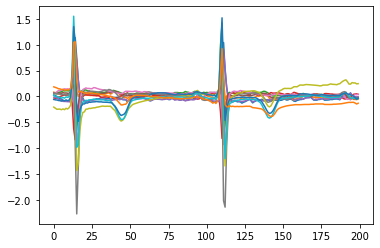

In [17]:
for i in range(12):
    plt.plot(ecg_train[0][:,i][:input_size])

In [18]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data, label):
        super().__init__()
        
        self.data = data
        self.label = label
        self.len = data.shape[0]
        
    def __len__(self):
        return self.len
    
    def __getitem__(self, index):
        out_data = self.data
#         new_length = np.random.randint(600,1000)
        new_length = 800
        out_data = out_data[index]
        
#         print(out_data.shape)
#         out_data = cv2.resize(out_data, (12,700))
        out_data = out_data * torch.normal(
            mean=torch.ones(out_data.shape), std=torch.ones(out_data.shape) * 0.1).to(device)

        start_idx = np.random.randint(0,new_length-input_size-1)
        out_data = out_data[start_idx:start_idx+input_size:,:]
        out_label = self.label[index]
#         print(out_data.shape)
        
        return out_data, out_label

In [19]:
# https://github.com/eddymina/ECG_Classification_Pytorch/blob/master/ECG_notebook.ipynb

import torch.nn as nn
import torch.nn.functional as F

print("""\nA 1D CNN is very effective when you expect to derive interesting features from shorter 
(fixed-length) segments of the overall data set and where the location of the feature 
within the segment is not of high relevance.\n""")

class Anomaly_Classifier(nn.Module):
    def __init__(self, input_size,num_classes):
        super(Anomaly_Classifier, self).__init__()
    
        self.conv= nn.Conv1d(in_channels=input_size, out_channels=32, kernel_size=5,stride=1)
        
        self.conv_pad = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=5,stride=1,padding=2)
        self.drop_50 = nn.Dropout(p=0.5)

        self.maxpool = nn.MaxPool1d(kernel_size=5,stride=2) 

#         self.dense1 = nn.Linear(32 * 8, 32) 
        self.dense1 = nn.Linear(1472, 32) 
        self.dense2 = nn.Linear(32, 32) 
        
        self.dense_final = nn.Linear(32, num_classes)

    def forward(self, x):
        s1, s2, s3 = x.shape
        x = x.reshape(s1, s3, s2)
        
        residual= self.conv(x)
      
        #block1 
        x = F.relu(self.conv_pad(residual))
        x = self.conv_pad(x)
        x+= residual 
        x = F.relu(x)
        residual = self.maxpool(x) #[512 32 90]
       
        #block2
        x=F.relu(self.conv_pad(residual))
        x=self.conv_pad(x)
        x+=residual
        x= F.relu(x)
        residual = self.maxpool(x) #[512 32 43]
        
        
        #block3
        x=F.relu(self.conv_pad(residual))
        x=self.conv_pad(x)
        x+=residual
        x= F.relu(x)
        residual = self.maxpool(x) #[512 32 20]
        
        
        #block4
        x=F.relu(self.conv_pad(residual))
        x=self.conv_pad(x)
        x+=residual
        x= F.relu(x)
        x= self.maxpool(x) #[512 32 8]
        
        s1, s2, s3 = x.shape
        
        #MLP
        x = x.view(-1, s2 * s3) #Reshape (current_dim, 32*2)
#         print(x.shape)
        
        x = F.relu(self.dense1(x))
        #x = self.drop_60(x)
        x= self.dense2(x)
        x = self.dense_final(x)
        x = x.view(-1)
        return x


A 1D CNN is very effective when you expect to derive interesting features from shorter 
(fixed-length) segments of the overall data set and where the location of the feature 
within the segment is not of high relevance.



In [20]:
class Net1D(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(12, 64, kernel_size=7, stride=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=7, stride=2)

        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, stride=1)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(128,256,kernel_size=3, stride=1)
        self.gap = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(256,1)


    def forward(self,x):
        s1, s2, s3 = x.shape
        x = x.reshape(s1, s3, s2)

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.conv3(x)
        x = self.gap(x)
        x = x.view(x.size(0),-1)
        x = self.fc(x)
        x = x.view(-1)

        return x

In [21]:
m = nn.Conv1d(12, 32, 7, stride=1, padding=3)
input = torch.randn(100, 12, 800)
m(input).shape


torch.Size([100, 32, 800])

In [22]:
input.shape

torch.Size([100, 12, 800])

In [23]:
m = nn.MaxPool1d(3, stride=2)
input = torch.randn(20, 16, 50)
output = m(input)

In [24]:

# https://github.com/Bjarten/early-stopping-pytorch modified
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0



In [25]:
cv = 0
list_stopepoch = []
list_weights = []
idx_valid_start = 100
for fold in range(n_splits):
#         print('FOLD : {}'.format(fold))
    X_train = ecg_train[folds[fold][0]] # 学習データの入力データを抽出
    y_train = target_train[folds[fold][0]] # 学習データの正解データを抽出
    X_valid = ecg_train[folds[fold][1]] # 検証データの入力データを抽出
    y_valid = target_train[folds[fold][1]] # 検証データの正解データを抽出
    
    X_valid = X_valid[:,idx_valid_start:idx_valid_start+input_size,:]
    
    X_train = torch.FloatTensor(X_train).to(device)
    y_train = torch.FloatTensor(y_train).to(device)
    X_valid = torch.FloatTensor(X_valid).to(device)
    y_valid = torch.FloatTensor(y_valid).to(device)

    dataset = MyDataset(X_train, y_train)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=100, shuffle=True)

        # Generate the model.
#     model = Anomaly_Classifier(num_classes= 1).to(device)
    model = Net1D().cuda()
    optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()
    
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=False)

    list_loss = []
    list_valloss = []
    best_auc = 0
    for e in range(EPOCHS):
        for i, (data, y_target) in enumerate(dataloader):
            optimizer.zero_grad()
            y_pred = model(data)
            loss = criterion(y_pred, y_target)
            if i == 0:
                list_loss.append(loss.item())
#                     writer.add_scalar("Loss/train", loss, e)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            y_pred = model(X_valid)
            valloss = criterion(y_pred, y_valid) 
            list_valloss.append(valloss.item())
#                 writer.add_scalar("Loss/validation", valloss, e)
            val_auc = roc_auc_score(y_valid.cpu().numpy(), y_pred.cpu().numpy())

#         if (verbose) & (e % 100 == 0) & (fold == 0):
        if (verbose) & (e % 100 == 0):
            print('E {}: train loss: {} val loss: {} val AUC: {}'.format(
                e, loss.item(), valloss.item(), val_auc))

#         if fold == 0:
#             trial.report(valloss, e)

#             # Handle pruning based on the intermediate value.
#             if trial.should_prune():
#                 raise optuna.exceptions.TrialPruned()
        if best_auc < val_auc:
            best_auc = val_auc
            best_weight = model.state_dict()

        early_stopping(-val_auc)

        if early_stopping.early_stop:
#                 print("Early stopping")
            break

    list_stopepoch.append(e-patience)
    list_weights.append(best_weight)
#     print(list_stopepoch)
# trial.set_user_attr('best_epoch', int(np.mean(list_stopepoch)-patience))
cv += min(list_valloss) / n_splits

E 0: train loss: 0.526840329170227 val loss: 0.604934811592102 val AUC: 0.6936904761904763
E 100: train loss: 0.21139805018901825 val loss: 0.3139428496360779 val AUC: 0.9157142857142857
E 200: train loss: 0.314350962638855 val loss: 0.33711910247802734 val AUC: 0.9244047619047618
E 300: train loss: 0.24876533448696136 val loss: 0.30031758546829224 val AUC: 0.9289285714285714
E 400: train loss: 0.15843622386455536 val loss: 0.32165947556495667 val AUC: 0.9219047619047619
E 500: train loss: 0.1177385002374649 val loss: 0.30356159806251526 val AUC: 0.9375
E 600: train loss: 0.1968621015548706 val loss: 0.47906652092933655 val AUC: 0.9110714285714286
E 700: train loss: 0.11896495521068573 val loss: 0.3146391808986664 val AUC: 0.9320238095238095
E 800: train loss: 0.18920131027698517 val loss: 0.3512440025806427 val AUC: 0.9276190476190476
E 900: train loss: 0.16269084811210632 val loss: 0.3586517870426178 val AUC: 0.9255952380952381
E 1000: train loss: 0.10874650627374649 val loss: 0.3698

In [26]:
best_epoch = int(np.mean(list_stopepoch))

In [27]:
for fold in range(n_splits):
#         print('FOLD : {}'.format(fold))
    X_train = ecg_train[folds[fold][0]] # 学習データの入力データを抽出
    y_train = target_train[folds[fold][0]] # 学習データの正解データを抽出
    X_valid = ecg_train[folds[fold][1]] # 検証データの入力データを抽出
    y_valid = target_train[folds[fold][1]] # 検証データの正解データを抽出

In [28]:
preds_train = np.zeros([n_splits, X_train.shape[0]], np.float32)
preds_valid = np.zeros([n_splits, X_valid.shape[0]], np.float32)

for fold, w in enumerate(list_weights):
    X_train = ecg_train[folds[fold][0]] # 学習データの入力データを抽出
    y_train = target_train[folds[fold][0]] # 学習データの正解データを抽出
    X_valid = ecg_train[folds[fold][1]] # 検証データの入力データを抽出
    y_valid = target_train[folds[fold][1]] # 検証データの正解データを抽出
    
    X_valid = X_valid[:,idx_valid_start:idx_valid_start+input_size,:]
    
    X_train = torch.FloatTensor(X_train).to(device)
#     y_train = torch.FloatTensor(y_train).to(device)
    X_valid = torch.FloatTensor(X_valid).to(device)
#     y_valid = torch.FloatTensor(y_valid).to(device)
    
    model = Net1D().to(device)
    model.load_state_dict(w)
    model.eval()
    with torch.no_grad():
        y_pred = model(X_valid)
        y_pred = F.sigmoid(y_pred).cpu().numpy()
        preds_valid[fold] = y_pred
        
    val_auc = roc_auc_score(y_valid, y_pred)
    print(val_auc)

0.9271428571428572
0.9430952380952381
0.9171428571428571
0.9011904761904762
0.9702380952380952


<AxesSubplot:>

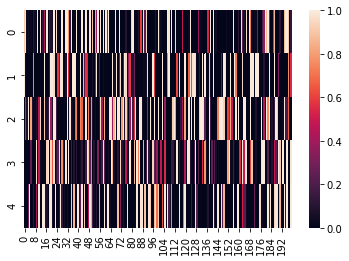

In [29]:
sns.heatmap(preds_valid)

In [54]:
preds_test = np.zeros([n_splits, len(df_test)], np.float32) # 予測結果の代入先
for fold, w in enumerate(list_weights):
#     model = Anomaly_Classifier(input_size=12, num_classes= 1).to(device)
    list_test = []

    model = Net1D().to(device)
    model.load_state_dict(w)
    model.eval()
    with torch.no_grad():
        for i in tqdm(range(0, 800 - input_size, 10)):
    #         print(i)
            y_test = ecg_test[:,i:i+input_size,:]
            print
            y_p = model(torch.FloatTensor(y_test).to(device))
            y_p = F.sigmoid(y_p).cpu().numpy()
            list_test.append(list(y_p))
    y_pred = np.array(list_test).mean(axis=0)
    preds_test[fold] = y_pred

100%|██████████| 60/60 [00:04<00:00, 13.94it/s]


<AxesSubplot:>

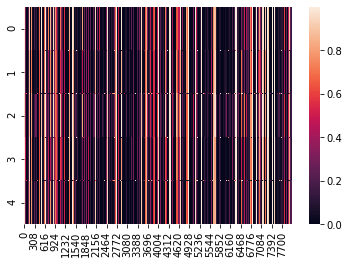

In [55]:
sns.heatmap(preds_test)

In [56]:
### submitファイルを作成
preds_test_mean = preds_test.mean(axis=0) # 各foldのmodelの予測の平均値を最終的な予測結果として採用する
print("preds_test_mean.shape: {}".format(preds_test_mean.shape))
df_sub[col_target] = preds_test.mean(axis=0) # 推定結果を代入
# df_sub[col_target] = preds_test[4]
df_sub.to_csv("submission.CV5.valid0.1.rl0.0007.Net1D.csv", index=None) # submitファイルを保存
df_sub.head() # 最初の5行を表示

preds_test_mean.shape: (8000,)


,Id,target
0,eee45832964560ae45040cbc95a252e7,0.070326
1,6a9adde92c964bd844ddeb12bf559130,0.650789
2,ee1f947df169cbdc8569a6959913c4ef,0.002494
3,611df0e51c4fcc5fd1a03887b031a2dc,0.078332
4,2aeae75bd1d6c3ad42574b68d4daf07c,0.414705


<AxesSubplot:>

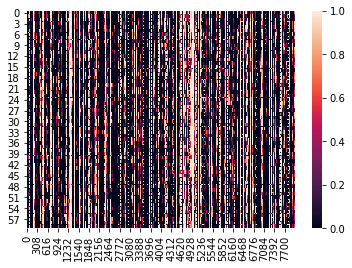

In [57]:
sns.heatmap(np.array(list_test))

In [49]:
y_pred

array([0.58487135, 0.96025616, 0.14961533, ..., 0.38871488, 0.6070465 ,
       0.5728578 ], dtype=float32)

In [32]:

import matplotlib.pyplot as plt 
import torch.optim as optim
import time 
import sklearn 
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import itertools


def reset_weights(model):
  """
  model.apply(reset_weights) will reset all the model parameters.
  This way the model is not overwhelmed 
  
  """
  if isinstance(model, nn.Conv1d) or isinstance(model, nn.Linear):
      model.reset_parameters()
      
def calc_accuracy(output,Y):
  
    # get acc_scores during training 
    max_vals, max_indices = torch.max(output,1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc
  
def train_model(data_loader, model, criterion,optimizer, n_epochs=100,print_every=10,verbose=True,plot_results=True,validation=True):
  
  """
  Model Training Function.
  Input:
    
    Dataloader: {'train':trainloader,'val':validloader} --> If no validation is used set Validation = False & dataloader= {'train':trainloader}
    model: model.cuda() if gpu will be used, else cpu
    print_every: print every n epochs 
    verbose: print out results per epoch 
    plot_results: plot the train and valid loss 
    validation: is validation set in dataloader
  
  Output:
  
    trained classifier 
  
  """

  losses=[]
  start= time.time()
  print('Training for {} epochs...\n'.format(n_epochs))
  for epoch in range(n_epochs):
      if verbose == True and epoch % print_every== 0:
        print('\n\nEpoch {}/{}:'.format(epoch+1, n_epochs))
        
      if validation == True: 
        evaluation=['train', 'val']
      else:
        
        evaluation=['train']
        
      # Each epoch has a training and validation phase
      for phase in evaluation:
          if phase == 'train': 
              model.train(True)  # Set model to training mode
          else:
              model.train(False)  # Set model to evaluate mode

          running_loss = 0.0

          # Iterate over data.
          for hb,labels in data_loader[phase]:
            for hb_index,label in enumerate(labels):
#                 print(hb[hb_index].size(),label.cpu().numpy().shape,Counter(label.cpu().numpy().flatten()))
                HB, label = hb[hb_index].unsqueeze(1).cuda(), label.cuda()

                # forward + backward + optimize
                outputs = model(HB)
                acc= calc_accuracy(outputs,label)
                loss = criterion(outputs, label)#loss function 
                # zero the parameter (weight) gradients
                optimizer.zero_grad()

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    # update the weights
                    optimizer.step()

                # print loss statistics
                running_loss += loss.item()

            losses.append(running_loss) 

          if verbose == True and epoch % print_every== 0: 
            print('{} loss: {:.4f} | acc: {:.4f}|'.format(phase, running_loss,acc), end=' ')
  if verbose == True:        
    print('\nFinished Training  | Time:{}'.format(time.time()-start))
  if plot_results == True:
    plt.figure(figsize=(10,10))
    plt.plot(losses[0::2],label='train_loss')
    if validation == True:
      plt.plot(losses[1::2],label='validation_loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.draw()
  
  return model 



def evaluate(testloader, trained_model,verbose= True):
  """
  Evaluation Metric Platfrom. Feed in the trained model 
  and test loader data. 
  
  Returns classification metric along with 
  predictions,truths
  
  """
  
  truth=[]
  preds=[]
  for hb,label in testloader:
      HB, label = hb.float().unsqueeze(1).cuda(), label.cuda()
      outputs = trained_model(HB)
      _, predicted = torch.max(outputs, 1)
      preds.append(predicted.cpu().numpy().tolist())
      truth.append(label.cpu().numpy().tolist())
  
  preds_flat = [item for sublist in preds for item in sublist]
  truth_flat = [item for sublist in truth for item in sublist] 
 

  if verbose == True:
    print('\nEvaluating....')
    print("TEST ACC:",accuracy_score(truth_flat,preds_flat))
    print(classification_report(truth_flat,preds_flat))
  
  return preds_flat,truth_flat



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
    
def get_kernel_size(n_h,k_h,n_w,k_w,p_h=0,s_h=1,p_w=0,s_w=1):
    """
    Kernel Measuring Function 
    """
    return [int((n_h-k_h+p_h+s_h)/s_h),int((n_w-k_w+p_w+s_w)/s_w)]    
    
    
def variation(n_epochs,num_iters=5):
  p=[]
  t=[]
  accuracy_scores=[]
  for i in range(num_iters):
    print('\nModel {}/{}...\n'.format(i+1,num_iters))
    Anomaly_Classifier(input_size=1,num_classes= 5).cuda().apply(reset_weights)
    print('Weights Reset')
    anom_classifier= Anomaly_Classifier(input_size=1,num_classes= 8).cuda()
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(anom_classifier.parameters(),lr = 0.001) 
    trained_classifier= train_model(data_loader=dataloader, model=anom_classifier,
                                    criterion = criterion,optimizer = optimizer ,
                                    n_epochs=n_epochs,print_every=1,verbose=False,plot_results=False, 
                                    validation=True)
    
    preds,truth = evaluate(testloader=testloader, trained_model = trained_classifier,verbose=False)
    t.append(truth)
    p.append(preds)
    print(accuracy_score(truth,preds))
    accuracy_scores.append(accuracy_score(truth,preds))
  return p,t,accuracy_scores
print('Functions Ready')

Functions Ready


In [ ]:
Anomaly_Classifier(input_size=1,num_classes= 2).cuda().apply(reset_weights)
print('Weights Reset')
anom_classifier= Anomaly_Classifier(input_size=1,num_classes= 2).cuda()
criterion = nn.NLLLoss()
optimizer = optim.Adam(anom_classifier.parameters(),lr = 0.001) 
trained_classifier2 = train_model(data_loader=dataloader, model=anom_classifier, criterion = criterion,optimizer = optimizer ,
                                            n_epochs=100,print_every=10,verbose=True,plot_results=True, validation=True)
preds,truth = evaluate(testloader=testloader, trained_model = trained_classifier2,verbose=True)